In [34]:
from datetime import datetime

import pandas as pd

from src.preview.emotion_preview import EmotionPreview
import csv
from pathlib import Path

### Wczytywanie logów z monitorowanych streamów

Zebraliśmy dane monitorując streamerów na platformie Twitch.tv za pomocą napisanej przez nas aplikacji znajdującej się w tym repozytorium.
Aplikacja wyświetla stream oraz predykuje emocje z twarzy osoby znajdującej się w zaznaczonym prostokącie. Wyniki zostają zapisane do określinego pliku `.csv` w celu dalszego przetwarzania.

![](images/image2.png)
![](images/image4.png)
![](images/image5.png)
![](images/image6.png)


In [45]:
def read_rows_from_file(saved_player_path: Path, **additional_values) -> pd.DataFrame:
    df_entries = []
    with saved_player_path.open("r") as file:
        reader = csv.reader(file)
        for date, *emotions in reader:
            for emotion_index, emotion_value in enumerate(emotions):
                entry = {
                    "date": datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f'),
                    "emotion_value": float(emotion_value),
                    "emotion_name": EmotionPreview.emotion_map[emotion_index],
                    **additional_values
                }
                df_entries.append(entry)
    return pd.DataFrame.from_dict(df_entries)

inputs = [
    ("Genshin Impact", 50, Path("logs/abyss.csv")),
    ("Genshin Impact", 50, Path("logs/abismitos.csv")),
    ("Genshin Impact", 50, Path("logs/ar59.csv")),
    ("Genshin Impact", 50, Path("logs/team_timmy.csv")),

    ("Dota2", 50, Path("logs/mrs_chim_chim.csv")),
    ("Dota2", 50, Path("logs/lumberjack.csv")),
]

def smooth_df(df, sigma):
    df_smoothed = df.copy()
    df_smoothed["emotion_value"] = df_smoothed["emotion_value"].astype(float)
    for emotion_name in df_smoothed["emotion_name"].unique():
        original = df_smoothed[df_smoothed["emotion_name"] == emotion_name]["emotion_value"]
        smoothed = gaussian_filter1d(original, sigma=sigma)
        df_smoothed.loc[df_smoothed["emotion_name"] == emotion_name, "emotion_value"] = smoothed
    return df_smoothed

dfs = [
    smooth_df(
        read_rows_from_file(saved_player_path, streamer=saved_player_path.stem, game=game),
        sigma=sigma
    )
    for game, sigma, saved_player_path in inputs
]



### Analiza emocji w czasie

Można zaobserwować, że różne osoby grające w te same gry mają mocno różniące się od siebie przebiegi emocji spredykowane z twarzy.
Jest to prawdopodobnie częściowo zależne od faktu, że kształt twarzy ma duży wpływ na działanie modelu, który był uczony na niewielkim zbiorze danych.
Co więcej model nie nauczył się poprawnie wykrywać emocji `contempt`.

Pomimo tych dużych niedociągnięć na przebiegach można zaobserwować zmiany emocji.
Przykładowy przebieg emocji dla krótkiego klipu Youtubera PewDiePie grającego w Subnautica. Pod koniec klipu youtuber zostaje wystraszony, a następnie siedzi niezadowolony.
Na modelu widać opisany skok emocji, jednak model niepoprawnie interpretuje przestraszony wyraz twarzy jako połączenie szczęścia i zaskoczenia (i częściowo rozumiemy jego decyzję).
Pod sam koniec klipu model całkiem słusznie wskazuje mieszankę złości i smutku.

![pewdiepie scream](images/pewdiepie_demo_readings_with_images.png)

Wykresy dla analizowanych streamerów znajdują się poniżej:


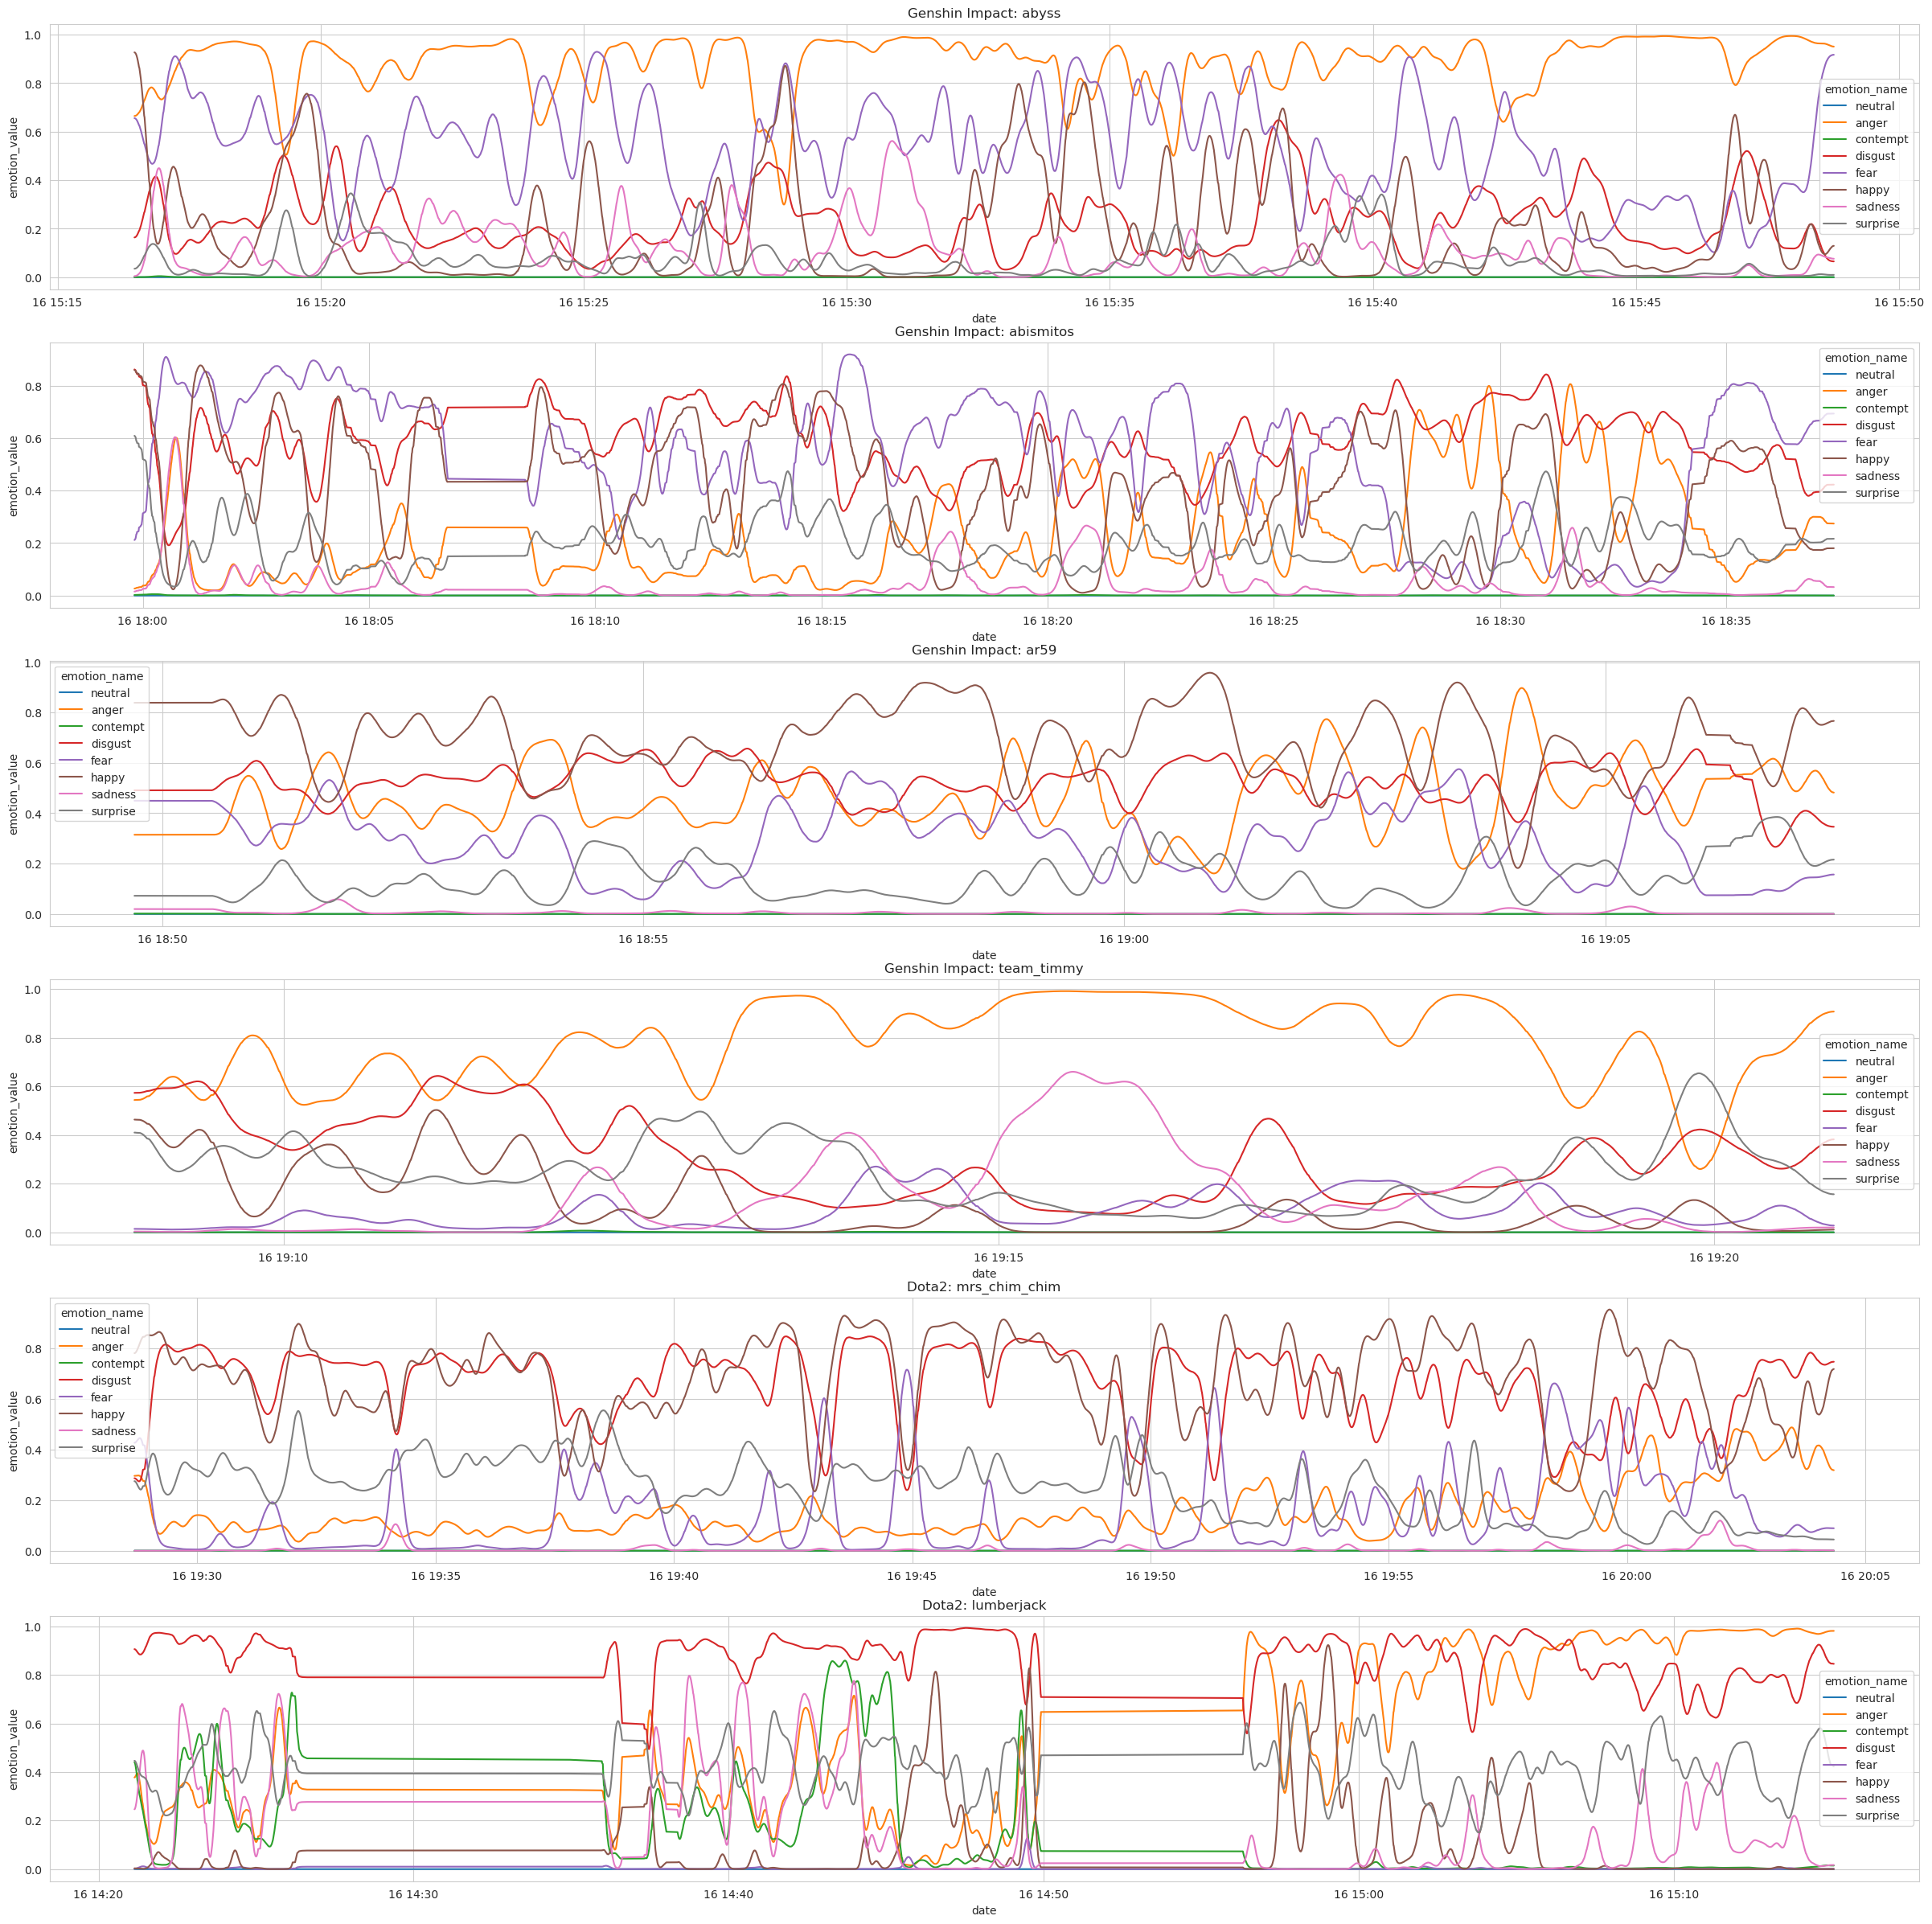

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d

fig, axs = plt.subplots(nrows=len(dfs), figsize=(30, 5*len(dfs)))
for smoothed_df, ax in zip(dfs, axs):
    sns.lineplot(smoothed_df, x="date", y="emotion_value", hue="emotion_name", ax=ax)
    ax.set_title(f"{smoothed_df['game'][0]}: {smoothed_df['streamer'][0]}")
plt.show()


### Analiza rozkładu emocji

W tej części przedstawioney jest rozkład emocji dla streamerów.
Można jeszcze lepiej zaobserwować to co było widać w poprzedniej części, a mianowicie, bardzo dużą różnicę w rozkładzie emocji między ludźmi.
U niektórych model wykrywa głównie `anger`, u innych głównie `happy`.

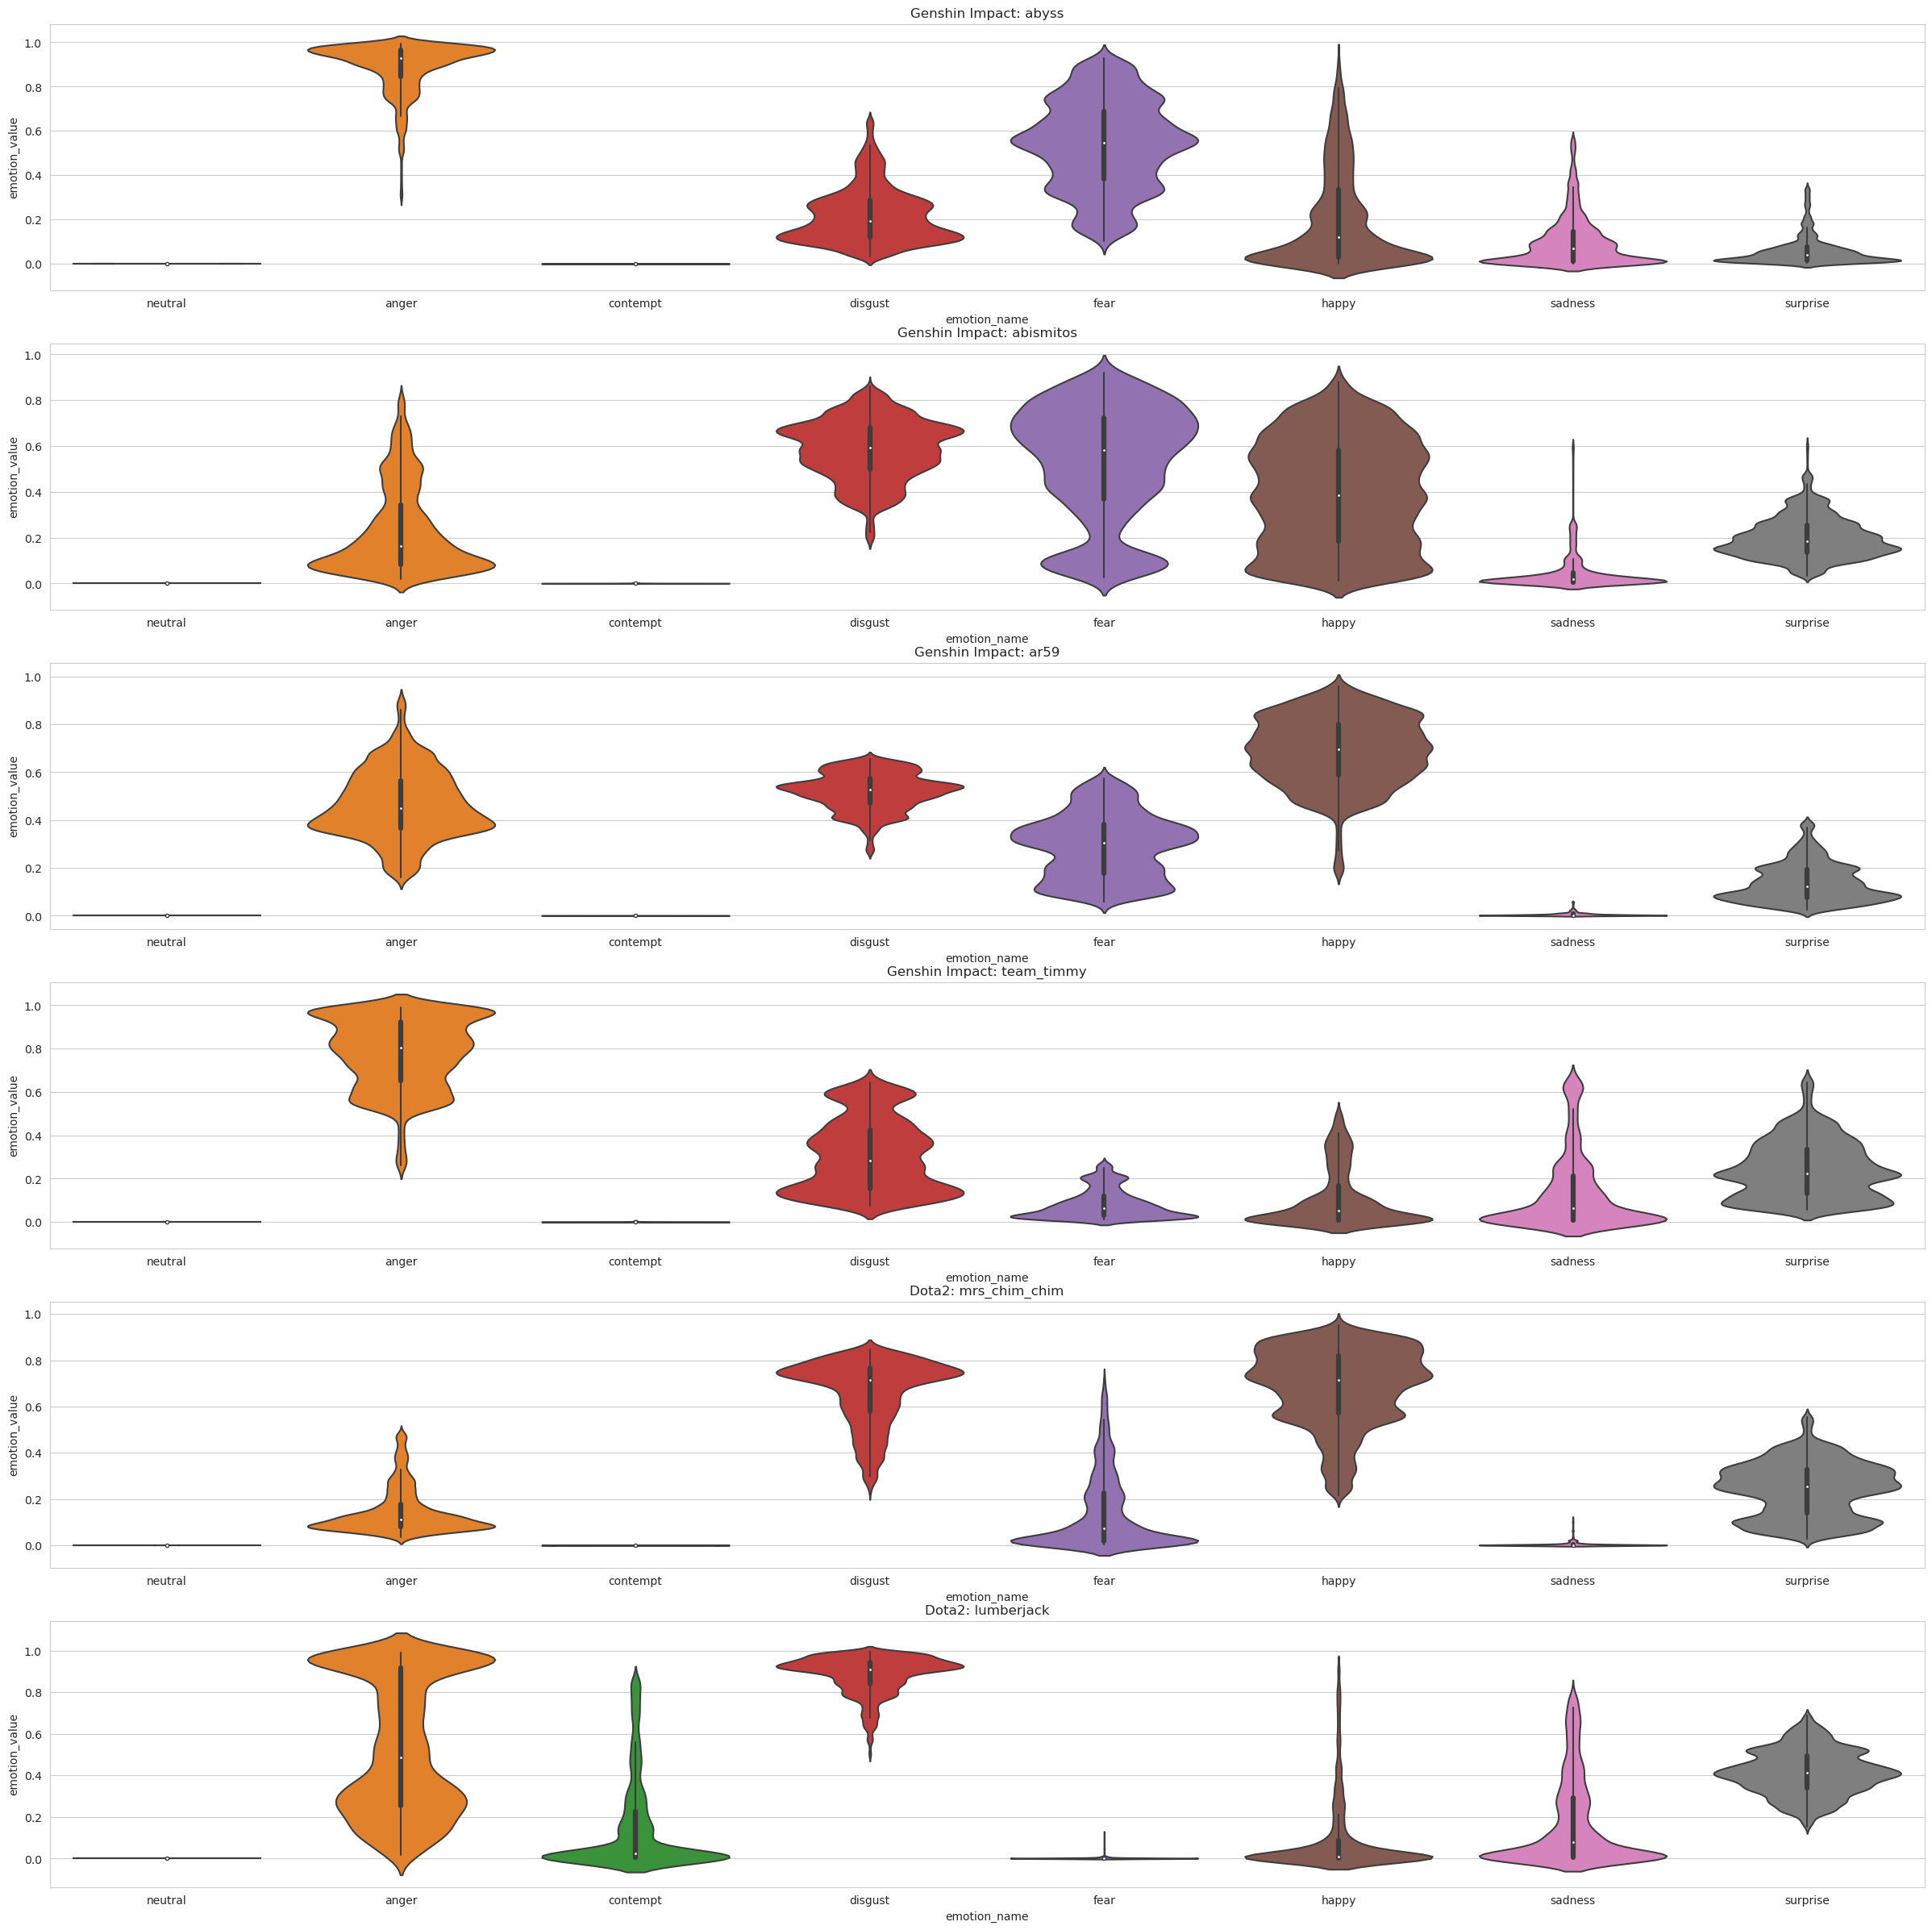

In [37]:
fig, axs = plt.subplots(nrows=len(dfs), figsize=(30, 5*len(dfs)))
for smoothed_df, ax in zip(dfs, axs):
    sns.violinplot(smoothed_df, x="emotion_name", y="emotion_value", ax=ax, scale="count")
    ax.set_title(f"{smoothed_df['game'][0]}: {smoothed_df['streamer'][0]}")
plt.show()

### Zestawienie wyników między grami
Analizowani streamerzy grali w grę `Genshin Impact` lub `Dota2`. Rozkład emocji jednej oraz drugiej grupy znajduje się na poniższym wykresie.
Należy zaznaczyć, że przy tak dużej wariancji emocji między graczami jednej gry należałoby zebrać ogromne ilości danych i włożyć znaczne ilości pracy w dalszą automatyzację tego procesu co wychodzi poza zakres tego projektu.

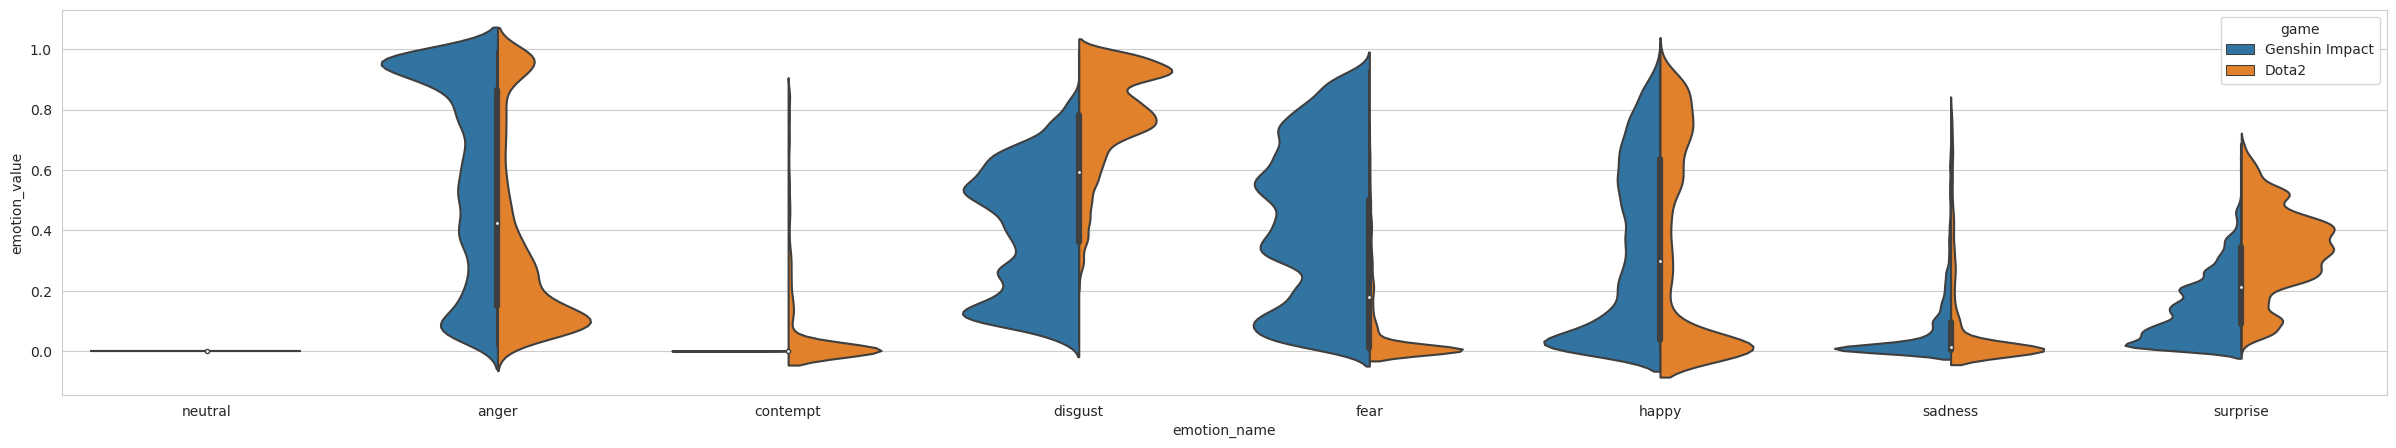

In [44]:
fig, ax = plt.subplots(figsize=(30, 5))
sns.violinplot(pd.concat(dfs, axis="rows"), x="emotion_name", y="emotion_value", scale="count", hue="game", split=True, ax=ax)
plt.show()